# Model FMV Tone Stack
Example of using a LT Spice netlist of the FMV Tone Stack to retrieve the transfer function & frequency response.

07/08/2024
Guillermo A. R.

In [1]:
from scipy.signal import freqs # for retrieve analog freq. response
import numpy as np # the meaning of life
import sympy as sp # symbolic notation
from symbolicspice import Circuit, plotTransfertFunction # magic library
import matplotlib.pyplot as plt # plotting

First, we need to declare a circuit object. We can either write a netlist by hand or just draw a circuit in LT Spice (following guidelines in README.md) and call the '.net' file.

In [2]:
circuit = Circuit(r'FMV Tone Stack.net')

We can get the symbolic continous transfer function between the output node and the input node. The input is always set as the first node and the ouput as the last node (if a label was set).

In [3]:
H = circuit.get_symbolic_transfert_function(output_node = 6, input_node = 1)
b, a = H.symbolic_analog_filter_coefficients()
print(f'\nb coefficients :{b}')
print(f'a coefficients :{a}')

                                                3                             
                                               s ⋅(C₁⋅C₂⋅C₃⋅R₁⋅Rb⋅Rm + C₁⋅C₂⋅C
──────────────────────────────────────────────────────────────────────────────
 3                                                                            
s ⋅(C₁⋅C₂⋅C₃⋅R₁⋅Rb⋅Rm + C₁⋅C₂⋅C₃⋅R₁⋅Rb⋅Rt₁ + C₁⋅C₂⋅C₃⋅R₁⋅Rb⋅Rt₂ + C₁⋅C₂⋅C₃⋅Rb⋅

                                                          2                   
₃⋅R₁⋅Rb⋅Rt₂ + C₁⋅C₂⋅C₃⋅Rb⋅Rm⋅Rt₁ + C₁⋅C₂⋅C₃⋅Rb⋅Rm⋅Rt₂) + s ⋅(C₁⋅C₂⋅R₁⋅Rb + C₁⋅
──────────────────────────────────────────────────────────────────────────────
                                2                                             
Rm⋅Rt₁ + C₁⋅C₂⋅C₃⋅Rb⋅Rm⋅Rt₂) + s ⋅(C₁⋅C₂⋅R₁⋅Rb + C₁⋅C₂⋅R₁⋅Rm + C₁⋅C₂⋅R₁⋅Rt₁ + 

                                                                              
C₂⋅R₁⋅Rm + C₁⋅C₂⋅R₁⋅Rt₂ + C₁⋅C₂⋅Rb⋅Rt₁ + C₁⋅C₂⋅Rb⋅Rt₂ + C₁⋅C₂⋅Rm⋅Rt₁ + C₁⋅C₂⋅R
──────────────────────────────────────────────────

Now let's get the frequency response from our transfer function.

In [4]:
# Create freq axis
f = np.geomspace(1,20000, num=1000)
w = 2*np.pi*f
# Get numerical analog coefficients
b_num, a_num =  H.numerical_analog_filter_coefficients()
# Get continuous frequency response
_, h = freqs(b_num, a_num, worN=w)

By exporting the results from LT Spice we can plot a comparison.

In [5]:
# Import LT Spice Results
data = open('FMV Tone Stack FR.txt','r')
lines = data.readlines()[1:]
data.close()
data = np.char.replace(lines, '\t', ',')
data = np.char.replace(data, '\n', '')
data = np.char.split(data, ',')

spiceF = np.zeros(len(data))
spiceH = np.zeros(len(data), dtype='complex')

for n, sample in enumerate(data):
    spiceF[n], spiceH[n]= float(sample[0]), float(sample[1]) + 1j * float(sample[2])

Plot results!

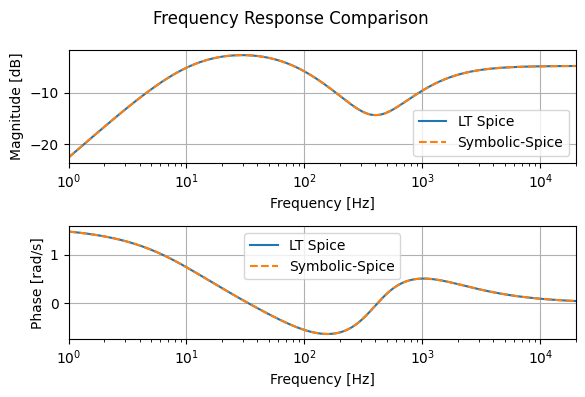

In [6]:
%matplotlib inline
plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.semilogx(spiceF, 20 * np.log10( np.abs(spiceH) ), label='LT Spice')
plt.semilogx(w/2/np.pi, 20 * np.log10( np.abs(h) ), label='Symbolic-Spice', linestyle='--')
plt.xlim((1,20e3))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.semilogx(spiceF, np.angle(spiceH), label='LT Spice')
plt.semilogx(w/2/np.pi, np.angle(h), label='Symbolic-Spice', linestyle='--')
plt.xlim((1,20e3))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [rad/s]')
plt.grid()
plt.legend()
plt.suptitle('Frequency Response Comparison')
plt.tight_layout()
plt.show()